In [4]:
from tqdm import tqdm
import numpy as np
import cv2
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import *
from keras.applications.efficientnet import *
from keras.preprocessing.image import ImageDataGenerator
from models import *
import os
import warnings

In [5]:
warnings.filterwarnings('ignore')
plt.rcParams["figure.dpi"] = 120
image_dimension = (224, 224)
epochs=100
batch_size = 32
epoch_index = [i for i in range(1, epochs+1)]

#### Check whether GPU is available

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Load Data, Label for prediction (currently use one dataset (Brain MRI Data2))

In [15]:
labels = {"glioma_tumor":1, "meningioma_tumor":2, "no_tumor":0, "pituitary_tumor":3}
dir_name = "MRI_DATA"
image_list = list()
truth_list = list()

for label, index in labels.items():
    path = os.path.join("Brain_MRI_data2", dir_name, label)
    images = os.listdir(path)
    for image in tqdm(images):
        current_image = cv2.imread(os.path.join(path, image))
        current_image = cv2.resize(current_image, image_dimension)
        image_list.append(current_image)
        truth_list.append(index)

features = np.array(image_list)/255.0 # rescale
labels = tf.keras.utils.to_categorical(truth_list)

100%|██████████| 2658/2658 [00:05<00:00, 470.35it/s]


In [16]:
print("image dimension: {}, label dimension: {}".format(features.shape, labels.shape))

image dimension: (10287, 224, 224, 3), label dimension: (10287, 4)


#### Define model saving function

In [17]:
def save_model(model_name):
    checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join("trained_model_weights", model_name),
                                 monitor='val_accuracy',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='max')
    return [checkpoint]

#### Split dataset into train, validation and test set

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=42, shuffle=True)
train_generator = ImageDataGenerator(validation_split=0.25)
test_generator = ImageDataGenerator()

train_df = train_generator.flow(X_train, y_train, batch_size=batch_size, subset="training")
validation_df = train_generator.flow(X_train, y_train, batch_size=batch_size, subset="validation")
test_df = train_generator.flow(X_test, y_test, batch_size=batch_size)

#### Use a simple CNN

In [19]:
simple_cnn_path = "simple_cnn.hdf5"
model_simple_cnn = simple_cnn()
model_simple_cnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_simple_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 43264)            

In [20]:
simple_cnn_history = model_simple_cnn.fit(train_df,
                                          epochs=epochs,
                                          verbose=1,
                                          validation_data=validation_df,
                                          callbacks=save_model(simple_cnn_path))

Epoch 1/100
181/181 [==============================] - 7s 26ms/step - loss: 1.3241 - accuracy: 0.3380 - val_loss: 1.2722 - val_accuracy: 0.4549

Epoch 00001: val_accuracy improved from -inf to 0.45488, saving model to trained_model_weights\simple_cnn.hdf5
Epoch 2/100
181/181 [==============================] - 4s 24ms/step - loss: 1.2621 - accuracy: 0.3643 - val_loss: 1.2161 - val_accuracy: 0.4533

Epoch 00002: val_accuracy did not improve from 0.45488
Epoch 3/100
181/181 [==============================] - 4s 24ms/step - loss: 1.2457 - accuracy: 0.3542 - val_loss: 1.1812 - val_accuracy: 0.4751

Epoch 00003: val_accuracy improved from 0.45488 to 0.47510, saving model to trained_model_weights\simple_cnn.hdf5
Epoch 4/100
181/181 [==============================] - 5s 25ms/step - loss: 1.2330 - accuracy: 0.3586 - val_loss: 1.1624 - val_accuracy: 0.4710

Epoch 00004: val_accuracy did not improve from 0.47510
Epoch 5/100
181/181 [==============================] - 4s 24ms/step - loss: 1.2153 - 

In [21]:
model_simple_cnn.load_weights(os.path.join("trained_model_weights", simple_cnn_path))
model_simple_cnn.evaluate(test_df)

81/81 [==============================] - 1s 17ms/step - loss: 0.1517 - accuracy: 0.9600


[0.15171615779399872, 0.9599533677101135]

Text(0.5, 1.0, 'Simple CNN Model')

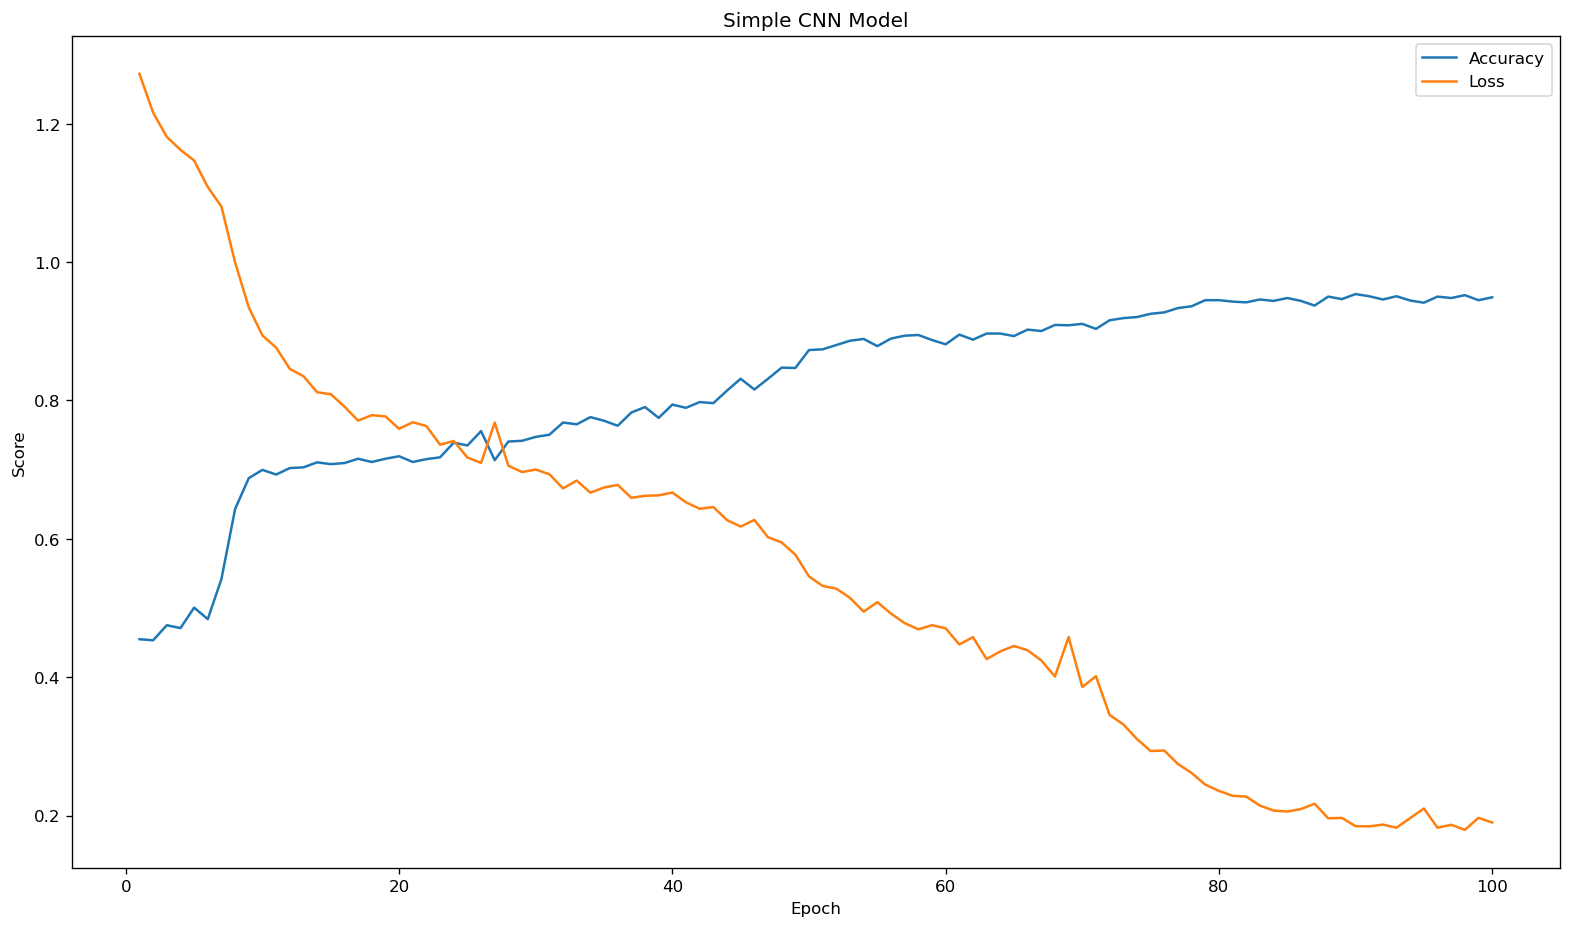

In [22]:
simple_cnn_result = pd.DataFrame({"Accuracy": simple_cnn_history.history["val_accuracy"],
                                  "Loss": simple_cnn_history.history["val_loss"]}, index=epoch_index)
simple_cnn_result.to_csv("Simple_CNN_result.csv")
ax_simple_cnn = simple_cnn_result.plot.line(figsize=(16, 9))
ax_simple_cnn.set_xlabel("Epoch")
ax_simple_cnn.set_ylabel("Score")
ax_simple_cnn.set_title("Simple CNN Model")

#### Using Resnet50

In [48]:
model_resnet_path = "resnet50.hdf5"
model_resnet = resnet_50()
model_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_resnet.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1000)              25636712  
_________________________________________________________________
input_8 (InputLayer)         multiple                  0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               256256    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 1028      
Total params: 25,893,996
Trainable params: 25,840,876
Non-trainable params: 53,120
_____________________________________

In [49]:
model_resnet_history = model_resnet.fit(train_df,
                 epochs=epochs,
                 verbose=1,
                 validation_data=validation_df,
                 callbacks=save_model(model_resnet_path))

Epoch 1/100
181/181 [==============================] - 25s 115ms/step - loss: 1.3580 - accuracy: 0.5054 - val_loss: 1.3862 - val_accuracy: 0.2334

Epoch 00001: val_accuracy improved from -inf to 0.23340, saving model to trained_model_weights\resnet50.hdf5
Epoch 2/100
181/181 [==============================] - 20s 111ms/step - loss: 1.3102 - accuracy: 0.7681 - val_loss: 1.3865 - val_accuracy: 0.2313

Epoch 00002: val_accuracy did not improve from 0.23340
Epoch 3/100
181/181 [==============================] - 20s 111ms/step - loss: 1.2718 - accuracy: 0.8569 - val_loss: 1.3798 - val_accuracy: 0.4025

Epoch 00003: val_accuracy improved from 0.23340 to 0.40249, saving model to trained_model_weights\resnet50.hdf5
Epoch 4/100
181/181 [==============================] - 20s 111ms/step - loss: 1.2343 - accuracy: 0.9266 - val_loss: 1.3459 - val_accuracy: 0.5389

Epoch 00004: val_accuracy improved from 0.40249 to 0.53890, saving model to trained_model_weights\resnet50.hdf5
Epoch 5/100
181/181 [===

Text(0.5, 1.0, 'Resnet50 Model')

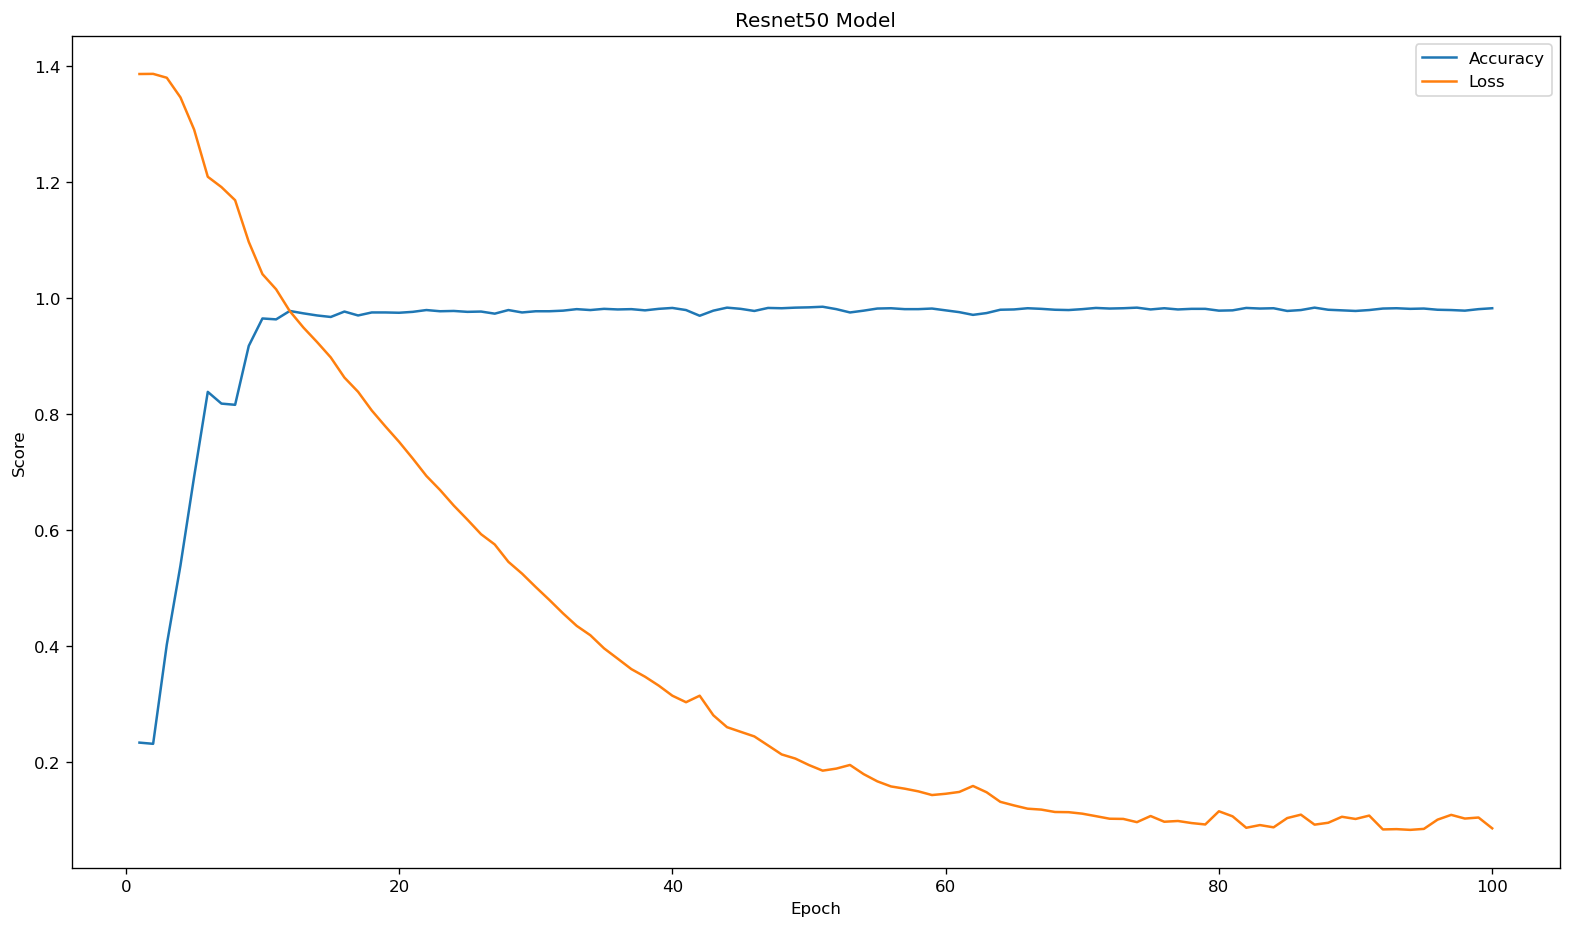

In [51]:
epoch_index = [i for i in range(1, epochs+1)]
resnet_result = pd.DataFrame({"Accuracy": model_resnet_history.history["val_accuracy"],
                                  "Loss": model_resnet_history.history["val_loss"]}, index=epoch_index)
resnet_result.to_csv("resnet_result.csv")
ax_resnet = resnet_result.plot.line(figsize=(16, 9))
ax_resnet.set_xlabel("Epoch")
ax_resnet.set_ylabel("Score")
ax_resnet.set_title("Resnet50 Model")

In [52]:
model_resnet.load_weights(os.path.join("trained_model_weights", model_resnet_path))
model_resnet.evaluate(test_df)

81/81 [==============================] - 3s 33ms/step - loss: 0.1748 - accuracy: 0.9899


[0.17478792369365692, 0.9898911118507385]

#### Using VGG-16

In [32]:
model_vgg16_path = "vgg16.hdf5"
model_vgg16 = vgg_16()
model_vgg16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
model_vgg16.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1000)              138357544 
_________________________________________________________________
flatten_4 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               128128    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 516       
Total params: 138,486,188
Trainable params: 138,486,188
Non-trainable params: 0
_________________________________________________________________


In [33]:
model_vgg16_history = model_vgg16.fit(train_df,
                                      verbose=1,
                                      epochs=epochs,
                                      validation_data=validation_df,
                                      callbacks=save_model(model_vgg16_path))

Epoch 1/100
181/181 [==============================] - 24s 130ms/step - loss: 1.3745 - accuracy: 0.3432 - val_loss: 1.3675 - val_accuracy: 0.4824

Epoch 00001: val_accuracy improved from -inf to 0.48237, saving model to trained_model_weights\vgg16.hdf5
Epoch 2/100
181/181 [==============================] - 23s 127ms/step - loss: 1.3623 - accuracy: 0.4069 - val_loss: 1.3609 - val_accuracy: 0.4632

Epoch 00002: val_accuracy did not improve from 0.48237
Epoch 3/100
181/181 [==============================] - 23s 127ms/step - loss: 1.3492 - accuracy: 0.4990 - val_loss: 1.3367 - val_accuracy: 0.6732

Epoch 00003: val_accuracy improved from 0.48237 to 0.67324, saving model to trained_model_weights\vgg16.hdf5
Epoch 4/100
181/181 [==============================] - 23s 127ms/step - loss: 1.3296 - accuracy: 0.6380 - val_loss: 1.3219 - val_accuracy: 0.6924

Epoch 00004: val_accuracy improved from 0.67324 to 0.69243, saving model to trained_model_weights\vgg16.hdf5
Epoch 5/100
181/181 [============

Text(0.5, 1.0, 'VGG16 Model')

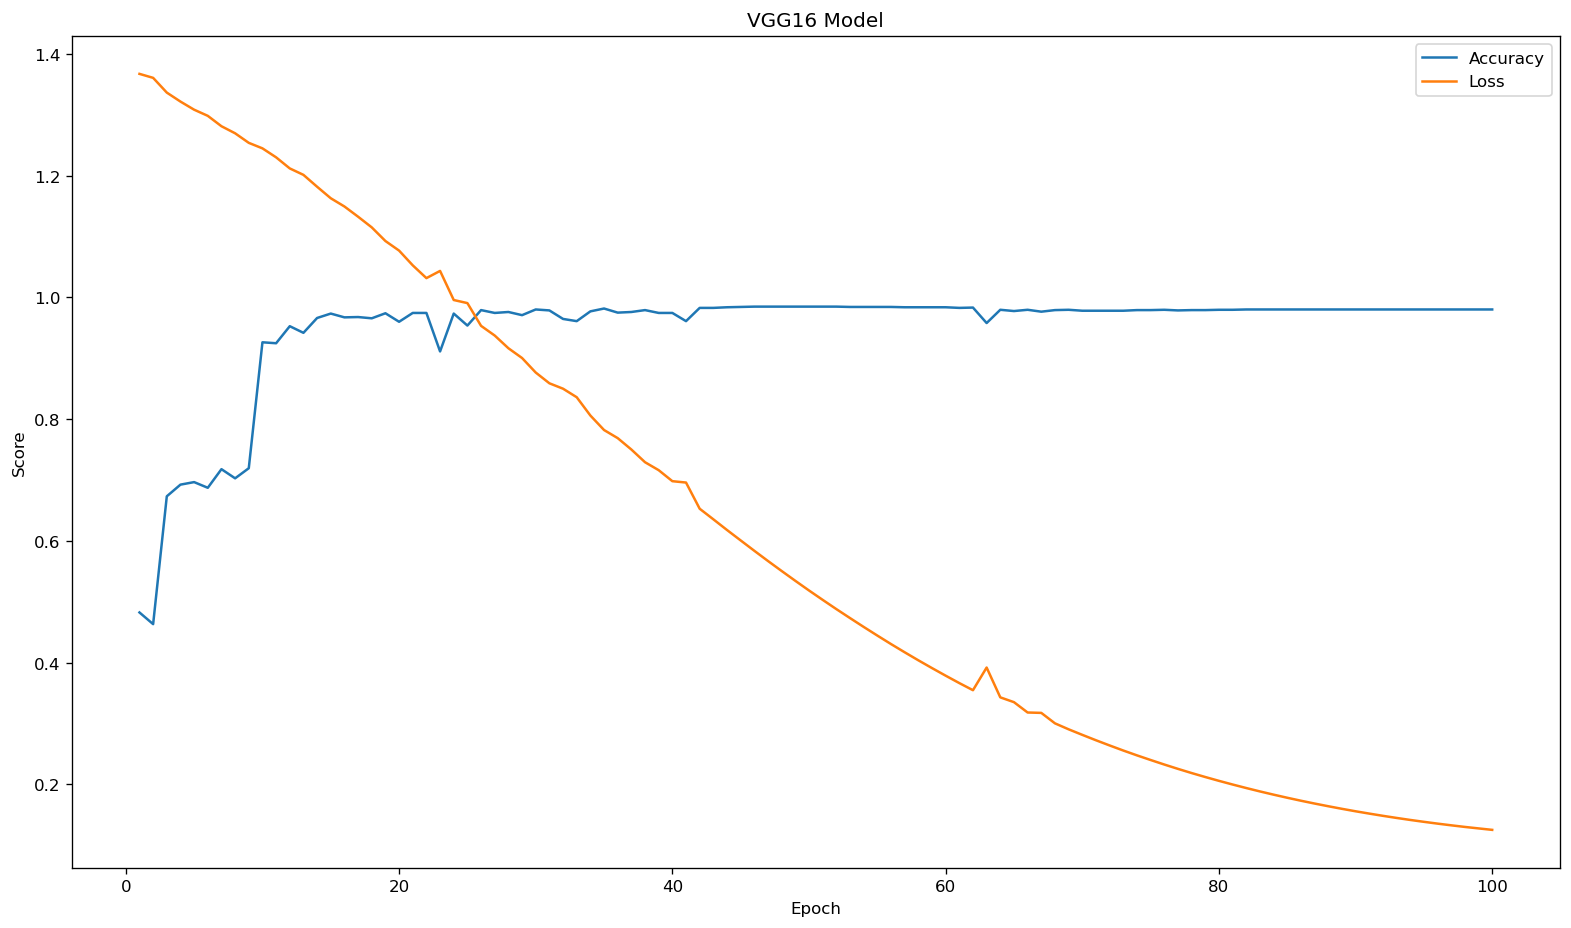

In [37]:
vgg16_result = pd.DataFrame({"Accuracy": model_vgg16_history.history["val_accuracy"],
                             "Loss": model_vgg16_history.history["val_loss"]}, index=epoch_index)
vgg16_result.to_csv("vgg16_result.csv")
ax_vgg16 = vgg16_result.plot.line(figsize=(16, 9))
ax_vgg16.set_xlabel("Epoch")
ax_vgg16.set_ylabel("Score")
ax_vgg16.set_title("VGG16 Model")

In [39]:
model_vgg16.load_weights(os.path.join("trained_model_weights", model_vgg16_path))
model_vgg16.evaluate(test_df)

81/81 [==============================] - 4s 42ms/step - loss: 0.5797 - accuracy: 0.9848


[0.5796564221382141, 0.9848366975784302]

#### Using VGG-19

In [41]:
model_vgg19_path = "vgg19.hdf5"
model_vgg19 = vgg_19()
model_vgg19.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
model_vgg19.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1000)              143667240 
_________________________________________________________________
flatten_6 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               128128    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 516       
Total params: 143,795,884
Trainable params: 143,795,884
Non-trainable params: 0
_________________________________________________________________


In [42]:
model_vgg19_history = model_vgg19.fit(train_df,
                                      verbose=1,
                                      epochs=epochs,
                                      validation_data=validation_df,
                                      callbacks=save_model(model_vgg19_path))

Epoch 1/100
181/181 [==============================] - 29s 152ms/step - loss: 1.3520 - accuracy: 0.5191 - val_loss: 1.3340 - val_accuracy: 0.6779

Epoch 00001: val_accuracy improved from -inf to 0.67790, saving model to trained_model_weights\vgg19.hdf5
Epoch 2/100
181/181 [==============================] - 27s 151ms/step - loss: 1.3282 - accuracy: 0.6584 - val_loss: 1.3188 - val_accuracy: 0.7018

Epoch 00002: val_accuracy improved from 0.67790 to 0.70176, saving model to trained_model_weights\vgg19.hdf5
Epoch 3/100
181/181 [==============================] - 28s 152ms/step - loss: 1.3121 - accuracy: 0.7007 - val_loss: 1.3050 - val_accuracy: 0.7111

Epoch 00003: val_accuracy improved from 0.70176 to 0.71110, saving model to trained_model_weights\vgg19.hdf5
Epoch 4/100
181/181 [==============================] - 28s 152ms/step - loss: 1.2965 - accuracy: 0.7225 - val_loss: 1.2979 - val_accuracy: 0.6888

Epoch 00004: val_accuracy did not improve from 0.71110
Epoch 5/100
181/181 [============

Text(0.5, 1.0, 'VGG16 Model')

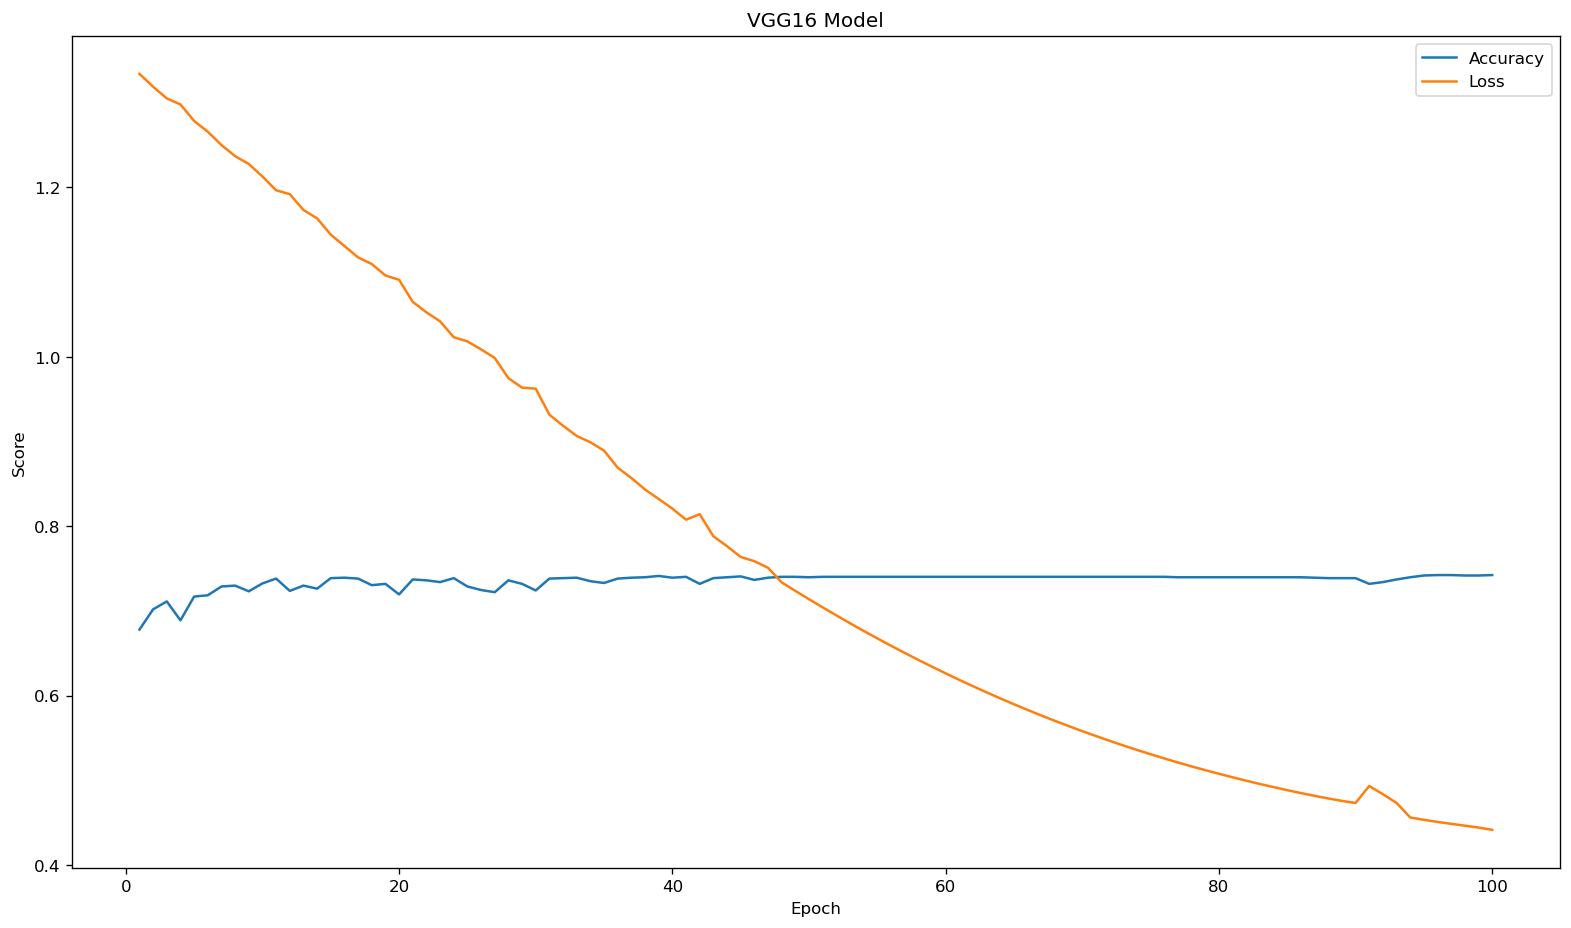

In [45]:
vgg19_result = pd.DataFrame({"Accuracy": model_vgg19_history.history["val_accuracy"],
                             "Loss": model_vgg19_history.history["val_loss"]}, index=epoch_index)
vgg19_result.to_csv("vgg19_result.csv")
ax_vgg19 = vgg19_result.plot.line(figsize=(16, 9))
ax_vgg19.set_xlabel("Epoch")
ax_vgg19.set_ylabel("Score")
ax_vgg19.set_title("VGG16 Model")

In [46]:
model_vgg19.load_weights(os.path.join("trained_model_weights", model_vgg19_path))
model_vgg19.evaluate(test_df)

81/81 [==============================] - 4s 43ms/step - loss: 0.4581 - accuracy: 0.7344


[0.4581001102924347, 0.7344478964805603]

#### Using efficientnet B3

<AxesSubplot:>

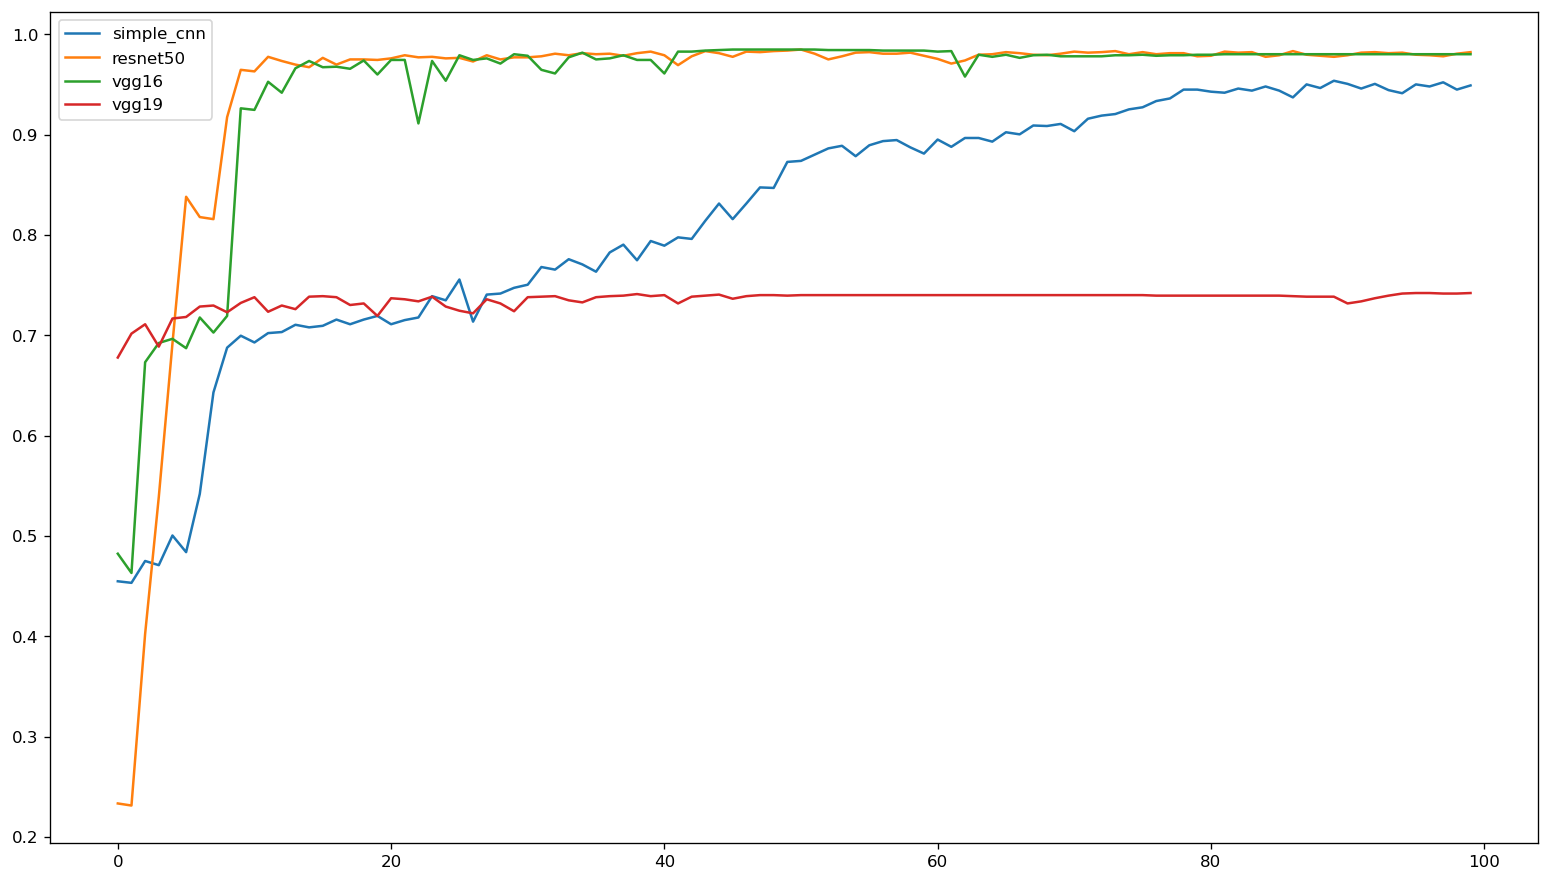

In [54]:
model_efficientnetB3_path = "efficientnetB3.hdf5"
model_efficientnetB3 = efficientnet(EfficientNetB3)
model_efficientnetB3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
model_efficientnetB3.summary()

In [ ]:
model_efficientnetB3_history = model_efficientnetB3.fit(train_df,
                                      verbose=1,
                                      epochs=epochs,
                                      validation_data=validation_df,
                                      callbacks=save_model(model_efficientnetB3_path))

In [ ]:
efficientnetB3_result = pd.DataFrame({"Accuracy": model_efficientnetB3_history.history["val_accuracy"],
                             "Loss": model_efficientnetB3_history.history["val_loss"]}, index=epoch_index)
efficientnetB3_result.to_csv("efficientnetB3_result.csv")
ax_efficientnetB3 = efficientnetB3_result.plot.line(figsize=(16, 9))
ax_vgg19.set_xlabel("Epoch")
ax_vgg19.set_ylabel("Score")
ax_vgg19.set_title("efficientnetB3 Model")

In [ ]:
model_efficientnetB3.load_weights(os.path.join("trained_model_weights", model_efficientnetB3_path))
model_efficientnetB3.evaluate(test_df)

<AxesSubplot:>

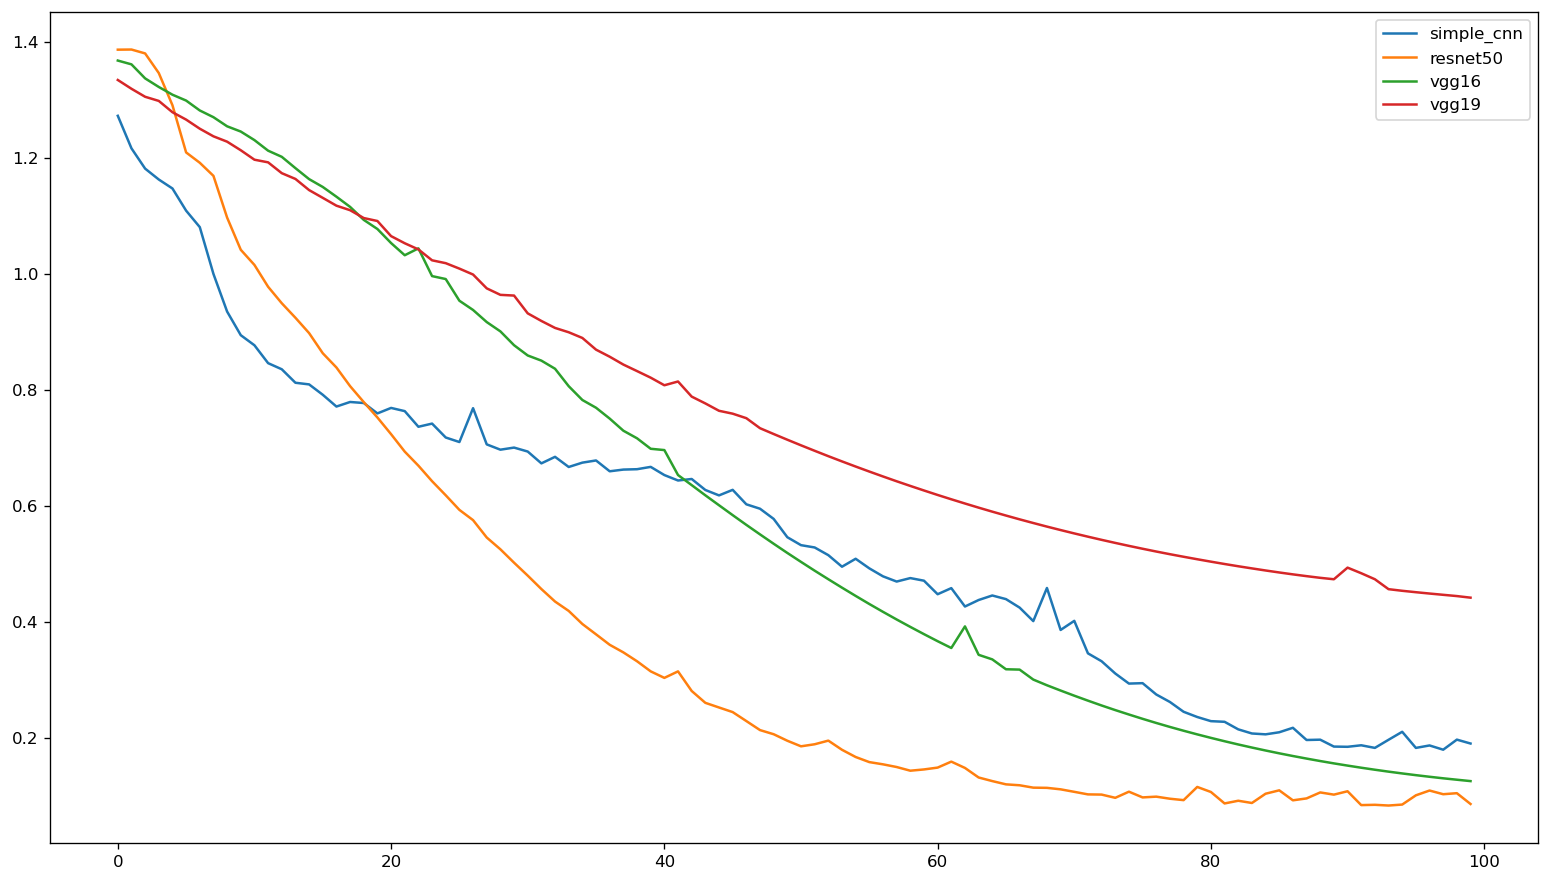

In [55]:
model_accuracy_compare = pd.DataFrame({"simple_cnn": simple_cnn_history.history["val_accuracy"],
                                       "resnet50": model_resnet_history.history["val_accuracy"],
                                       "vgg16": model_vgg16_history.history["val_accuracy"],
                                       "vgg19": model_vgg19_history.history["val_accuracy"]})
model_accuracy_compare.plot.line(figsize=(16, 9))


model_loss_compare = pd.DataFrame({"simple_cnn": simple_cnn_history.history["val_loss"],
                                       "resnet50": model_resnet_history.history["val_loss"],
                                       "vgg16": model_vgg16_history.history["val_loss"],
                                       "vgg19": model_vgg19_history.history["val_loss"]})
model_loss_compare.plot.line(figsize=(16, 9))